In [1]:
import os
import cv2
import numpy as np
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# Dataset Directory
data_dir = "C:/Users/Melike/Desktop/DL/images"

In [3]:
# Classes
sub_folders = os.listdir(data_dir)

In [5]:
# Declaring the lists for images and labels
images = []
labels = []

In [6]:
# Accessing the labels
for sub_folder in sub_folders:
    label = sub_folder

    # Constructing the path to the current sub-folder
    path = os.path.join(data_dir, sub_folder)

    # Listing all images in the current sub-folder
    sub_folder_images = os.listdir(path)

    # Accessing the Images
    for image_name in sub_folder_images:
        # Constructing the path to the current image
        image_path = os.path.join(path, image_name)
        # Loading the image using OpenCV
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        # Appending the image to the list of images
        images.append(img)
        # Appending the label corresponding to the current sub-folder to the list of labels
        labels.append(label)

In [7]:
# Converting the lists of images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)
print(len(images))

15066


In [8]:
# Splitting Dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

In [9]:
# Preprocess the image
def preprocessing(img):
    img = img / 255.0
    img = cv2.resize(img, (48, 48))
    return img.reshape(-1, 48, 48, 1)  # Reshape to match input shape

In [10]:
# Apply preprocessing to training, validation, and test sets
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

In [11]:
# Reshape input data to remove unnecessary dimension
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

In [12]:
# Initialize ImageDataGenerator for data augmentation
data_gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    rotation_range=10
)

# Compute necessary statistics for data augmentation
data_gen.fit(X_train)

In [13]:
# Encode the class labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

In [14]:
# Encode the class labels for training, validation, and test sets
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [15]:
# Get the number of classes
num_classes = len(label_encoder.classes_)

# Convert encoded class labels to one-hot encoded categorical arrays
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_val_categorical = to_categorical(y_val, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

In [16]:
# Building Model
def build_model():
    model = Sequential()
    # 1st Layer
    model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    # 2nd Layer
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    # 3rd layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    # 4th layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    # Flatten Layer
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())

    # Fully connected layer 2
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [17]:
# Build the model
model = build_model()

# Print model summary
print(model.summary())

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 4,346,114 (16.58 MB)

 Trainable params: 4,342,146 (16.56 MB)

 Non-trainable params: 3,968 (15.50 KB)

None


In [18]:
# Initialize ModelCheckpoint callback
# checkpoint = ModelCheckpoint("model.h5", monitor="val_acc", verbose=1, save_best_only=True)
# Initialize ModelCheckpoint callback
checkpoint = ModelCheckpoint("model.keras", monitor="val_acc", verbose=1, save_best_only=True)

In [19]:
# Initialize EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

In [20]:
# Initialize ReduceLROnPlateau callback
reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)

In [21]:
# List of callbacks
callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

In [22]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [23]:
# Training the model
history = model.fit(
    data_gen.flow(X_train, y_train_categorical, batch_size=128),
    validation_data=(X_val, y_val_categorical),
    epochs=50,
    verbose=1
)

Epoch 1/50


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 32s 351ms/step - accuracy: 0.5989 - loss: 0.8823 - val_accuracy: 0.4005 - val_loss: 0.9998
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 30s 346ms/step - accuracy: 0.7096 - loss: 0.5656 - val_accuracy: 0.5995 - val_loss: 2.2219
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 29s 345ms/step - accuracy: 0.7742 - loss: 0.4768 - val_accuracy: 0.5995 - val_loss: 2.5844
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 359ms/step - accuracy: 0.8216 - loss: 0.3902 - val_accuracy: 0.4005 - val_loss: 2.9397
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 32s 375ms/step - accuracy: 0.8396 - loss: 0.3561 - val_accuracy: 0.4113 - val_loss: 2.7664
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 32s 369ms/step - accuracy: 0.8576 - loss: 0.3207 - val_accuracy: 0.7438 - val_loss: 0.5127
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.8754 - loss: 0.2929 - val_accuracy: 0.7479 - val_loss: 0.5525
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.8923 - loss: 0.2564 - val_accuracy: 0.813

In [24]:
# Save the model with .keras extension
model.save("modelv3.keras")

In [25]:
# Saving the model with .h5 extension
model.save('modelv3.h5')

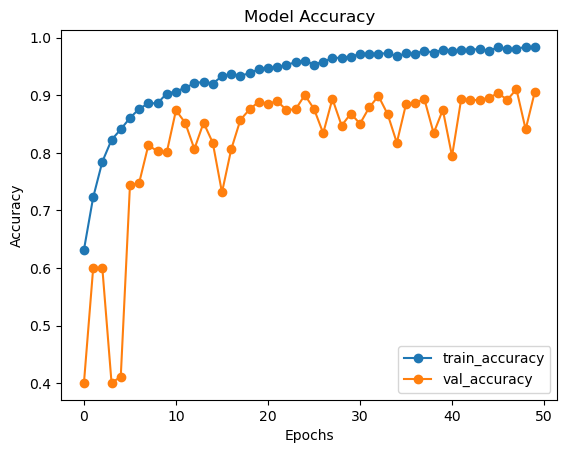

In [26]:
# Plotting model performance
plt.plot(history.history['accuracy'], label='train_accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()